# Исследовательский анализ данных

# Проект: Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей, для **определения возраста клиентов**, что позволит анализировать покупки и предлагать товары, которые могут заинтересовать покупателей определенной возрастной группы, а так же контролировать добросовестность кассиров при продаже алкоголя.\
В нашем распоряжении набор фотографий людей с указанием возраста.

**Цель проекта:** разработать модель машинного обучения, которая по фотографии определит приблизительный возраст человека. 

**Ход исследования:** \
Шаг 1 - Загрузка и исследовательский анализ данных; \
Шаг 2 - Подготовка данных к обучению; \
Шаг 3 - Обучение нейронной сети и рассчет её качества; \
Шаг 4 - Итоговый вывод.

**Описание данных:**

Данные взяты с сайта *ChaLearn Looking at People*. Они находятся в папке `/datasets/faces/`.

Все изображения находятся в одной папке: /final_files. \
В той же папке находится csv-файл labels.csv с двумя колонками: file_name и real_age - названием файла с изображением и значением возраста человека на этом изображении.

## Шаг 1. Загрузка и исследовательский анализ данных

Загружаем библиотеки, которые понадобятся в нашем исследовании

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)

### 1.1 Загрузим данные из csv-файла в датафрейм c помощью библиотеки pandas

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')

### 1.2 Изучим общую информацию о датафрейе. Выведим первые строки набора данных.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Перед нами датафрейм на **2** колонки и **7591**  строк. Пропущенные значения не обнаружены. \
Названия колонок соответствуют общепринятым нормам. \
Посмотрим первые 5 строчек таблицы:

In [4]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Содержимое данных соответствует описанию, типы данных корректные. 

Предлагаю вызвать описательную функцию и посмотреть значения возрастов покупателей в нашем датасете: 

In [5]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Таблица содержит данные о 7591 фотографии.\
Средний возраст покупателей — **31** год.

Имеются фотографии людей с возрастом в 1 год,а так же 100 лет, что скорее всего является выбросами - посмотрим на гистограмме:

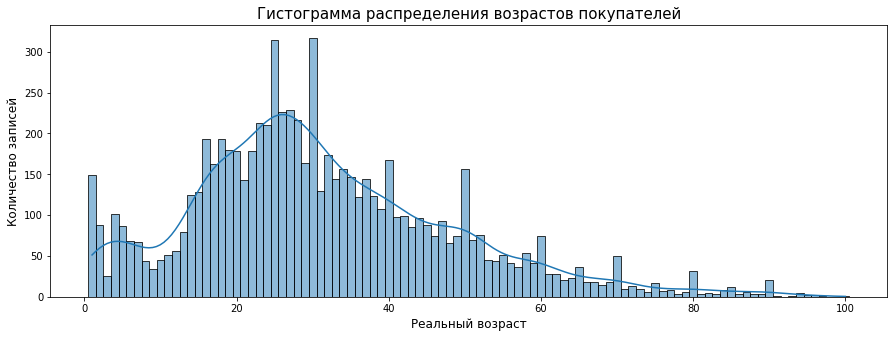

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
sns.histplot(data = data, 
             x = 'real_age', 
             discrete = True,
             kde = True
             )

plt.title('Гистограмма распределения возрастов покупателей', size = 15)
     
plt.ylabel('Количество записей', size = 12)
plt.xlabel('Реальный возраст', size = 12)
plt.show()

Распределение принимает вид нормального, со сдвигом влево. Пики данных могут быть вызваны тем, что некоторые округляли свой возраст.\
Для выявления выбросов построим Боксплот:

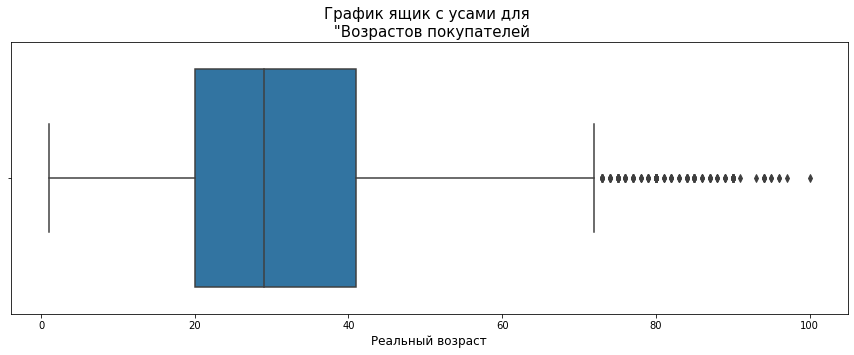

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
sns.boxplot(data = data, 
            x = 'real_age', 
            )\

plt.title('График ящик с усами для \n "Возрастов покупателей', size = 15)
     
plt.xlabel('Реальный возраст', size = 12)
plt.show()

Покупатели старше 70 лет - уже считаются выбросами, однако, по моему мнению - нейросеть должна быть готова ко всему, не стоит удалять эти выбросы. 

Выведем на экран несколько случайных изображений, для этого загрузим нужные изображения.

In [8]:
datagen = ImageDataGenerator(rescale=1/255)

In [9]:
datagen_flow = datagen.flow_from_dataframe(
        dataframe = data,
        directory = f'/datasets/faces/final_files',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (150, 150),
        batch_size = 16,
        class_mode = 'raw',
        seed = 123)

Found 7591 validated image filenames.


In [10]:
features, target = next(datagen_flow)

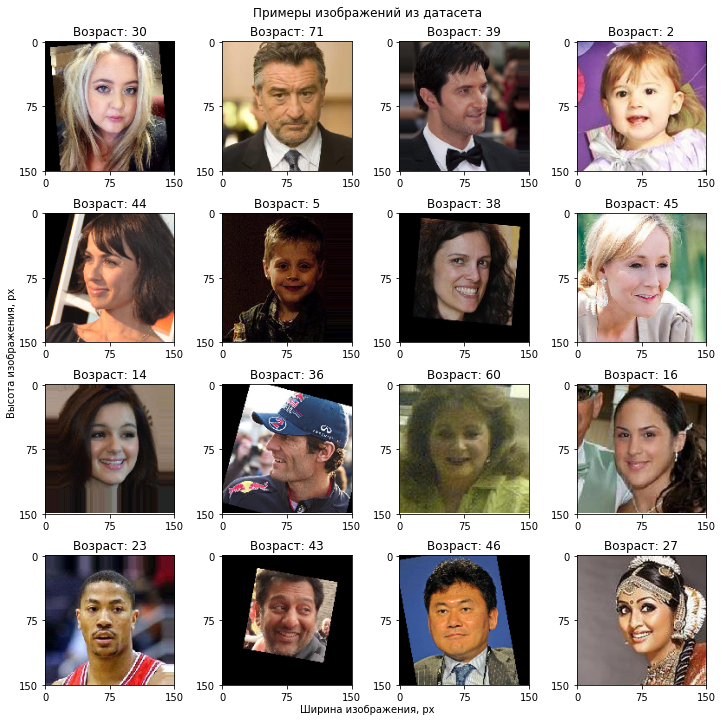

In [11]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('Примеры изображений из датасета')
fig.text(.5,0,'Ширина изображения, px', ha='center')
fig.text(0,.5,'Высота изображения, px', va='center', rotation='vertical')
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([0,75,150])
    plt.yticks([0,75,150])
    plt.tight_layout()
    plt.title(f'Возраст: {target[i]}')

Представленные изображения имеют размер **150 х 150** пикселей. Видно, что произведены предобработка изображений, так как лица находятся в центре и фотографии ориентированы вертикально. Так же отметим, что возраст покупателей верно размечен. 

Посмотрим ещё немного фотографий, например людей из выбросов - старше 70 лет.

In [12]:
oldschool = data[data['real_age'] >= 70]

In [13]:
datagen_flow_old = datagen.flow_from_dataframe(
        dataframe = oldschool,
        directory = f'/datasets/faces/final_files',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (150, 150),
        batch_size = 16,
        class_mode = 'raw',
        seed = 123)

Found 242 validated image filenames.


In [14]:
features, target = next(datagen_flow_old)

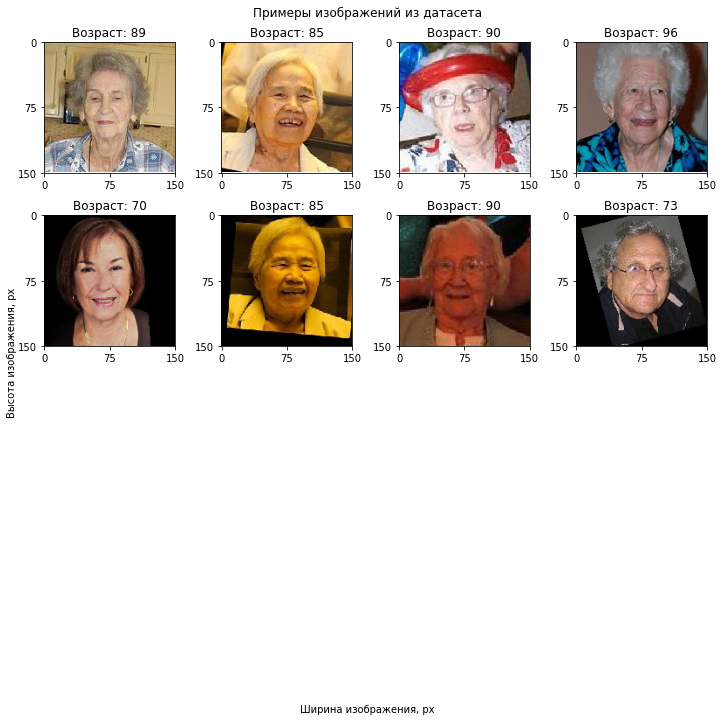

In [15]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Примеры изображений из датасета')
fig.text(.5,0,'Ширина изображения, px', ha='center')
fig.text(0,.5,'Высота изображения, px', va='center', rotation='vertical')
for i in range(8):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([0,75,150])
    plt.yticks([0,75,150])
    plt.tight_layout()
    plt.title(f'Возраст: {target[i]}')

Видим, что с разметкой возраста проблем не наблюдается.

### Вывод:
В нашем распоряжении папка с фотографиями, а также таблица, в которой указан возраст человека на фото.\
В таблице содержатся записи о 7591 фотографии. Средний возраст людей на них — 31 год. 

После проведения исследовательского анализа данных, можем сказать, что распределение возрастов относится к нормальному, данные размечены корректно, имеются выбросы, но они не помешают в нашей работе. 

При выводе случайных фотографий людей не обнаружили фотографий с некорректно размеченным возрастом. \
Также видно, что над фотографиями проведена предобработка - оригиналы сделаны под разными углами, видимо ранее с ними уже была произведена аугментация и при обучении модели этот шаг можно будет упростить.

Данные готовы для обучения модели, следовательно *ШАГ 2* мы пропускаем и переходим к следующему шагу:

## Шаг 3 Обучение нейронной сети и рассчет её качества

```python
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50 


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
        horizontal_flip = True,
        rescale = 1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + "/final_files/",
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (150, 150),
        batch_size = 16,
        class_mode = 'raw',
        subset = 'training',
        seed = 123)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split = 0.25,
        rescale = 1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path +'/final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (150, 150),
        batch_size = 16,
        class_mode = 'raw',
        subset = 'validation',
        seed = 123)

    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape = (150, 150, 3),
                        weights = 'imagenet',
                        include_top = False)
    optimizer = Adam(lr = 0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation ='relu'))
    model.compile(optimizer = optimizer,
                  loss = 'mean_squared_error',
                  metrics = ['mae'])

    return model

def train_model(model, train_data, test_data, batch_size = None, epochs = 5,
                steps_per_epoch = None, validation_steps = None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data = test_data,
              batch_size = batch_size,
              epochs = epochs,
              steps_per_epoch = steps_per_epoch,
              validation_steps = validation_steps,
              verbose = 2)

    return model
```

Результат работы модели: 

``` python
Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 65s - loss: 232.4457 - mae: 11.1071 - val_loss: 453.6038 - val_mae: 16.0368
Epoch 2/5
356/356 - 36s - loss: 88.5140 - mae: 7.1105 - val_loss: 124.3602 - val_mae: 8.4525
Epoch 3/5
356/356 - 36s - loss: 58.9799 - mae: 5.8180 - val_loss: 84.6134 - val_mae: 7.0450
Epoch 4/5
356/356 - 36s - loss: 41.3454 - mae: 4.9159 - val_loss: 86.0635 - val_mae: 7.0277
Epoch 5/5
356/356 - 36s - loss: 30.6105 - mae: 4.2406 - val_loss: 77.6776 - val_mae: 6.6510

119/119 - 9s - loss: 77.6776 - mae: 6.6510
TEST MAE = 6.65 лет. 
```

# Итоговый вывод: 
В данном исследовании перед нами стояла *задача* `разработать модель машинного обучения, которая по фотографии определит приблизительный возраст человека`.\
На этапе исследовательского анализа данных мы выяснили, что в нашем распоряжении находится папка с 7591 фотографиями, а также таблица, в которой указан возраст человека на фото. Как мы далее выяснили, средний возраст людей на них — 31 год.\
Распределение возрастов относится к *нормальному*, данные размечены *корректно* и `предобработка` даннных своими силами не потребуется. 
 
- Была использована модель сверточной нейронной сети ResNet50 - она имеет 50 слоев. 
При обучении мы использовали следующие параметры и улучшения:
1. Sequential из Keras - просто линейный набор слоев нейронной сети
2. Слой ResNet50 (указал на входе размер изображений 150х150 так как в тренажере у меня с этим размером метрики считались лучше, тогда как в стандартном виде модель принимает на вход разрешение 224х224 пикселя).
3. Cлой GlobalAveragePooling2D - глобальной средней подвыборки(субдискретизации)
4. Cлой Dense - обычный плотно связанный слой с активацией нейронов ReLU
5. Слой Adam - оптимизируем параметры при помощи оптимизатора.

MAE за **5** эпох удалось уменьшить с **16.4** до **6.65** лет, далее, комбинировал количество эпох, чтобы MAE стала меньше года - для точности продажи продукции `18+`, но особо я к этому результату не приблизился. 

*В итоге при обучении модели мы добились значение MAE на уровне **4.24** на обучающей выборке и **6.65** лет на тестовой.*

По моему мнению, необходимо улучшать точность модели до минимальной ошибки, так как одним из критериев заказчика служит *контроль добросовестности кассиров при продаже алкоголя* и соответственно если модель пропускает продажу алкоголя несовершеннолетним - магазин может намотаться на большой штраф. 
